# TabNet regression example for Metro Interstate Traffic Volume dataset

This notebook shows 
  - a simple workflow using TabNet for regression, [UCI ML repo](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume)
  - how to get global feature importances from the model
  - how to show local feature importances (masks) from the model
  - a comparison to XGBoost and LightGBM


In [1]:
try:
  from pytorch_tabnet.tab_model import TabNetRegressor
except:
  !pip install pytorch-tabnet
  from pytorch_tabnet.tab_model import TabNetRegressor

In [2]:
try:
  import wget
except:
  !pip install wget
  import wget

In [3]:
import torch; print('torch: ', torch.__version__)

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import pandas as pd; print('pandas:', pd.__version__)
import numpy as np

import os
import shutil
import gzip

from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

from pprint import PrettyPrinter
pprint = PrettyPrinter().pprint

import psutil
print('CPU count:', psutil.cpu_count())

torch:  1.5.1+cu101
pandas: 1.0.5
CPU count: 2


# Download dataset

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz"
dataset_name = 'metro_interstate_traffic_volume'
tmp_out = Path('./data/'+dataset_name+'.gz')
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [5]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file as", tmp_out, "...")
    wget.download(url, tmp_out.as_posix())
    print("Extracting data to", out)
    with gzip.open(tmp_out, 'rb') as f_in:
        with open(out, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print('done')

File already exists.


# Load data and split

In [6]:
df = pd.read_csv(out, parse_dates=['date_time'])
print('loaded data with shape:', df.shape)

loaded data with shape: (48204, 9)


In [7]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [8]:
columns = pd.DataFrame({'column':df.columns})
columns['dtype']   = df.dtypes.values
columns['nunique'] = df.nunique().values
columns['missing'] = df.isnull().sum().values
columns

,column,dtype,nunique,missing
0,holiday,object,12,0
1,temp,float64,5843,0
2,rain_1h,float64,372,0
3,snow_1h,float64,12,0
4,clouds_all,int64,60,0
5,weather_main,object,11,0
6,weather_description,object,38,0
7,date_time,datetime64[ns],40575,0
8,traffic_volume,int64,6704,0


In [9]:
print(df['date_time'].min())
print(df['date_time'].max())

2012-10-02 09:00:00
2018-09-30 23:00:00


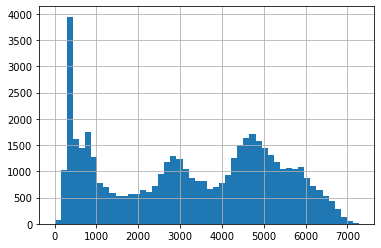

In [10]:
target = 'traffic_volume'
df[target].hist(bins=50);

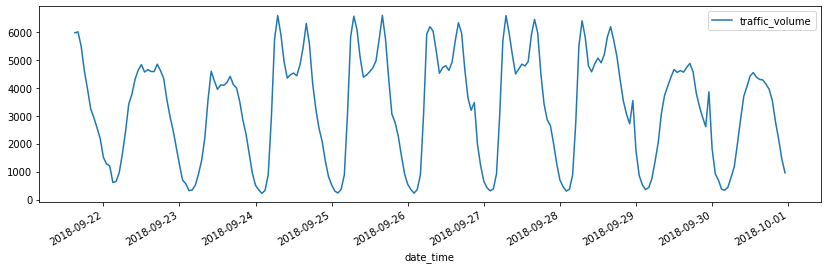

In [11]:
df.loc[:, ['date_time', 'traffic_volume']].tail(24*10).plot(x='date_time', y='traffic_volume', figsize=(14,4))

In [12]:
# time series regression, split on date for validation
df['set'] = 'train'

df.loc[df['date_time']>='2018-08-01', 'set'] = 'valid'
df.loc[df['date_time']>='2018-09-01', 'set'] = 'test'

df['set'].value_counts()

train    46323
valid      946
test       935
Name: set, dtype: int64

# Features

In [13]:
exclude = ['traffic_volume', 'set']

## Datetime features

In [14]:
def add_datetime_features(df, col, add_time_features=False, scale_0_to_1=True, cos_sin_transform=True):
    """
    Create common date and time features out of given datetime-columns.
    Optional to scale between 0 and 1.
    """
    
    new_cols = []
    
    if cos_sin_transform:
        scale_0_to_1 = True
    
    # make sure column has a datetime-
    df[col] = pd.to_datetime(df[col])
    
    df[f'dt_{col}_year']        = df[col].dt.year
    df[f'dt_{col}_month']       = df[col].dt.month        
    df[f'dt_{col}_week']        = df[col].dt.week
    df[f'dt_{col}_day']         = df[col].dt.day
    df[f'dt_{col}_dayofweek']   = df[col].dt.dayofweek
    df[f'dt_{col}_dayofyear']   = df[col].dt.dayofyear
    df[f'dt_{col}_daysinmonth'] = df[col].dt.daysinmonth
    
    if add_time_features:
        df[f'dt_{col}_hour'] = df[col].dt.hour
        df[f'dt_{col}_min']  = df[col].dt.minute
        df[f'dt_{col}_sec']  = df[col].dt.second
        
    if scale_0_to_1:
        max_year = df[f'dt_{col}_year'].max()
        min_year = df[f'dt_{col}_year'].min()
        df[f'dt_{col}_year']        = (df[f'dt_{col}_year'] - min_year) / (max_year - min_year)
        
        df[f'dt_{col}_month']       = df[f'dt_{col}_month']     / 12
        df[f'dt_{col}_week']        = df[f'dt_{col}_week']      / 52
        df[f'dt_{col}_dayofweek']   = df[f'dt_{col}_dayofweek'] / 7
        df[f'dt_{col}_day']         = df[f'dt_{col}_day']       / df[f'dt_{col}_daysinmonth']
        df[f'dt_{col}_dayofyear']   = df[f'dt_{col}_dayofyear'] / 366
        df[f'dt_{col}_daysinmonth'] = df[f'dt_{col}_daysinmonth'] / 31
    
        if add_time_features:
            df[f'dt_{col}_hour'] = df[f'dt_{col}_hour'] / 24
            df[f'dt_{col}_min']  = df[f'dt_{col}_min']  / 60
            df[f'dt_{col}_sec']  = df[f'dt_{col}_sec']  / 60
            
            
    if cos_sin_transform:
        for seasonal_part in ['month', 'week', 'dayofweek']:
            df[f'dt_{col}_{seasonal_part}_cos'] = np.round(np.cos(df[f'dt_{col}_{seasonal_part}']      * 2 * np.pi), 4)
            df[f'dt_{col}_{seasonal_part}_sin'] = np.round(np.sin(df[f'dt_{col}_{seasonal_part}']      * 2 * np.pi), 4)
    
        if add_time_features:
            for seasonal_part in ['hour', 'min', 'sec']:
                df[f'dt_{col}_{seasonal_part}_cos'] = np.round(np.cos(df[f'dt_{col}_{seasonal_part}']      * 2 * np.pi), 4)
                df[f'dt_{col}_{seasonal_part}_sin'] = np.round(np.sin(df[f'dt_{col}_{seasonal_part}']      * 2 * np.pi), 4)
        
    new_cols = [col for col in df.columns if col.startswith(f'dt_')]
                
    return df, new_cols

In [15]:
df, columns_dt = add_datetime_features(df, 'date_time', add_time_features=True)
pprint(columns_dt)

['dt_date_time_year',
 'dt_date_time_month',
 'dt_date_time_week',
 'dt_date_time_day',
 'dt_date_time_dayofweek',
 'dt_date_time_dayofyear',
 'dt_date_time_daysinmonth',
 'dt_date_time_hour',
 'dt_date_time_min',
 'dt_date_time_sec',
 'dt_date_time_month_cos',
 'dt_date_time_month_sin',
 'dt_date_time_week_cos',
 'dt_date_time_week_sin',
 'dt_date_time_dayofweek_cos',
 'dt_date_time_dayofweek_sin',
 'dt_date_time_hour_cos',
 'dt_date_time_hour_sin',
 'dt_date_time_min_cos',
 'dt_date_time_min_sin',
 'dt_date_time_sec_cos',
 'dt_date_time_sec_sin']


In [16]:
df.loc[:, columns_dt].sample(5)

,dt_date_time_year,dt_date_time_month,dt_date_time_week,dt_date_time_day,dt_date_time_dayofweek,dt_date_time_dayofyear,dt_date_time_daysinmonth,dt_date_time_hour,dt_date_time_min,dt_date_time_sec,dt_date_time_month_cos,dt_date_time_month_sin,dt_date_time_week_cos,dt_date_time_week_sin,dt_date_time_dayofweek_cos,dt_date_time_dayofweek_sin,dt_date_time_hour_cos,dt_date_time_hour_sin,dt_date_time_min_cos,dt_date_time_min_sin,dt_date_time_sec_cos,dt_date_time_sec_sin
9959,0.166667,0.916667,0.903846,0.600000,0.000000,0.879781,0.967742,0.625000,0.0,0.0,0.866,-0.5,0.8230,-0.5681,1.0000,0.0000,-0.7071,-0.7071,1.0,0.0,1.0,0.0
33996,0.833333,0.416667,0.403846,0.806452,0.428571,0.396175,1.000000,0.083333,0.0,0.0,-0.866,0.5,-0.8230,0.5681,-0.9010,0.4339,0.8660,0.5000,1.0,0.0,1.0,0.0
7521,0.166667,0.583333,0.538462,0.258065,0.000000,0.516393,1.000000,0.541667,0.0,0.0,-0.866,-0.5,-0.9709,-0.2393,1.0000,0.0000,-0.9659,-0.2588,1.0,0.0,1.0,0.0
37480,0.833333,0.750000,0.750000,0.866667,0.142857,0.734973,0.967742,0.250000,0.0,0.0,-0.000,-1.0,-0.0000,-1.0000,0.6235,0.7818,0.0000,1.0000,1.0,0.0,1.0,0.0
28949,0.666667,1.000000,0.942308,0.290323,0.571429,0.939891,1.000000,0.375000,0.0,0.0,1.000,-0.0,0.9350,-0.3546,-0.9010,-0.4339,-0.7071,0.7071,1.0,0.0,1.0,0.0


In [17]:
# drop columns with just one unique value (data is aggregated to hours)
df = df.drop(['dt_date_time_min', 'dt_date_time_sec',
              'dt_date_time_min_cos', 'dt_date_time_min_sin', 'dt_date_time_sec_cos', 'dt_date_time_sec_sin'], axis=1)

## Categorical

In [18]:
# specify which columns to regard as categorical
columns_catg = ['holiday', 'weather_main', 'weather_description', 
                'dt_date_time_year', 'dt_date_time_month', 'dt_date_time_week', 'dt_date_time_day', 'dt_date_time_dayofweek', 
                'dt_date_time_daysinmonth', 
                'dt_date_time_hour', 
                ]

In [19]:
  # create new label encoded categorical columns, keep original columns
  for col in columns_catg:
    df[col] = df[col].fillna("00_MISSING")
    df[col+'__label'] = LabelEncoder().fit_transform(df[col].values)

In [20]:
def get_categorical_features(df) -> list:
  "get list of numerical categorical features"
  feats_catg = [c for c in df.columns if c.endswith('__label')]
  return feats_catg


features_catg = get_categorical_features(df)
pprint(features_catg)

['holiday__label',
 'weather_main__label',
 'weather_description__label',
 'dt_date_time_year__label',
 'dt_date_time_month__label',
 'dt_date_time_week__label',
 'dt_date_time_day__label',
 'dt_date_time_dayofweek__label',
 'dt_date_time_daysinmonth__label',
 'dt_date_time_hour__label']


In [21]:
features_all = [col for col in df.select_dtypes('number').columns
                if col not in exclude]

print(len(features_all), 'features: ', features_all)

features_catg_idxs = [i for i, f in enumerate(features_all) if f in features_catg]

30 features:  ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'dt_date_time_year', 'dt_date_time_month', 'dt_date_time_week', 'dt_date_time_day', 'dt_date_time_dayofweek', 'dt_date_time_dayofyear', 'dt_date_time_daysinmonth', 'dt_date_time_hour', 'dt_date_time_month_cos', 'dt_date_time_month_sin', 'dt_date_time_week_cos', 'dt_date_time_week_sin', 'dt_date_time_dayofweek_cos', 'dt_date_time_dayofweek_sin', 'dt_date_time_hour_cos', 'dt_date_time_hour_sin', 'holiday__label', 'weather_main__label', 'weather_description__label', 'dt_date_time_year__label', 'dt_date_time_month__label', 'dt_date_time_week__label', 'dt_date_time_day__label', 'dt_date_time_dayofweek__label', 'dt_date_time_daysinmonth__label', 'dt_date_time_hour__label']


# Splits

In [22]:
X_train = df.loc[df['set']=='train', features_all].values
y_train = df.loc[df['set']=='train', target].values

X_valid = df.loc[df['set']=='valid', features_all].values
y_valid = df.loc[df['set']=='valid', target].values

X_test = df.loc[df['set']=='test', features_all].values
y_test = df.loc[df['set']=='test', target].values

print('train:', X_train.shape, '| valid:', X_valid.shape, '| test:', X_test.shape)

train: (46323, 30) | valid: (946, 30) | test: (935, 30)


# TabNet

In [23]:
def get_categorical_dims(df, features_catg) -> list:
  "get list ov dimensions for each categorical column"
  return list(df[features_catg].nunique().values)


def get_embedding_dims(df, features_catg, method='ln'):
  """
  Calculate dimensions for embeddings per feature. Larger dims can learn more but require longer training.
  Method:
  - int for same size for all features
  - 'sqrt' for square root of category counts
  - 'ln' for logn of category counts
  - 'fastai' for fastai sizes
  """

  emb_dims = []

  for f in features_catg:
    n_unique = df[f].nunique()
    
    if type(method)==int:  emb_dims.append( method )
    elif method=='sqrt':   emb_dims.append( int(np.sqrt(n_unique)) )
    elif method=='ln':     emb_dims.append( max(int(np.log(n_unique)), 1) )
    elif method=='fastai': emb_dims.append( min(600, round(1.6 * n_unique**0.56)) )

  return emb_dims

In [24]:
cat_dims = get_categorical_dims(df, features_catg)
print('cat dims:    ', cat_dims)

cat_emb_dim = get_embedding_dims(df, features_catg, method='ln')
print('cat emb dims:', cat_emb_dim)

cat dims:     [12, 11, 38, 7, 12, 53, 114, 7, 4, 24]
cat emb dims: [2, 2, 3, 1, 2, 3, 4, 1, 1, 3]


In [25]:
# create estimator, default values
est = TabNetRegressor(n_d=8, n_a=8, n_steps=3, gamma=1.3, 
                      cat_idxs=features_catg_idxs, 
                      cat_dims=cat_dims,
                      cat_emb_dim=cat_emb_dim, 
                      optimizer_fn=torch.optim.Adam,
                      optimizer_params={'lr':0.02}, 
                      scheduler_fn=torch.optim.lr_scheduler.StepLR,
                      scheduler_params={"gamma": 0.5, "step_size": 10},
                      )

Device used : cpu


## Training

In [26]:
# default values, takes about 360s on a 2 core CPU (Google Colab)
est.fit(  
    X_train=X_train, y_train=y_train.reshape(-1, 1),
    X_valid=X_valid, y_valid=y_valid.reshape(-1, 1),
    max_epochs=100 , patience=10, 
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

Will train until validation stopping metric hasn't improved in 10 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | -14449821.00000 |  -15010134.00000 |   4.9       
| 2     | -13863387.00000 |  -13894443.00000 |   9.8       
| 3     | -12635407.00000 |  -12139713.00000 |   14.7      
| 4     | -10703302.00000 |  -10065251.00000 |   19.5      
| 5     | -8394888.00000 |  -7681773.50000 |   24.2      
| 6     | -6076614.00000 |  -5172964.50000 |   29.3      
| 7     | -3955559.75000 |  -2407300.00000 |   34.1      
| 8     | -2152195.25000 |  -1528137.87500 |   38.8      
| 9     | -1045298.81250 |  -750533.68750 |   43.6      
| 10    | -564895.87500 |  -243840.26562 |   48.3      
| 11    | -387775.00000 |  -470552.96875 |   53.1      
| 12    | -362625.90625 |  -170297.17188 |   57.9      
| 13    | -308615.21875 |  -195382.75000 |   62.8      
| 14    | -280526.71875 |  -138570.43750 |   67.7      
| 15    | -256843.28125 |  -253

In [27]:
print('best score:', -est.best_cost)

best score: -52817.625


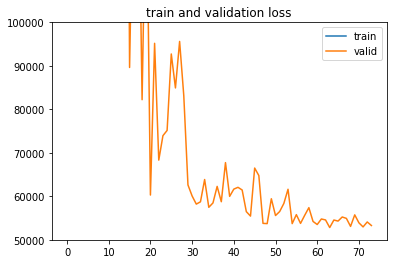

In [28]:
# plot losses
plt.plot(est.history['train']['loss'], label='train')
plt.plot(est.history['valid']['loss'], label='valid')
plt.title('train and validation loss');
plt.ylim(50_000, 100_000)
plt.legend();

## Predictions

In [29]:
tabnet_preds_test = est.predict(X_test)
tabnet_test_mse = metrics.mean_squared_error(y_true=y_test, y_pred=tabnet_preds_test)

print(f"valid MSE: {est.best_cost:,.2f}")
print(f"test  MSE: {tabnet_test_mse:,.2f}")

valid MSE: 52,817.62
test  MSE: 112,007.75


## Global explainability: feat importance summing to 1

In [30]:
feat_imp = (pd.DataFrame({'feature':features_all,
                          'importance':np.round(est.feature_importances_, 4)})
            .sort_values('importance', ascending=False)
            .reset_index(drop=True)
)
feat_imp.style.bar()

,feature,importance
0,dt_date_time_hour__label,0.321500
1,dt_date_time_week_cos,0.206900
2,dt_date_time_year,0.161900
3,dt_date_time_month,0.129800
4,dt_date_time_dayofweek,0.107200
5,weather_description__label,0.038900
6,dt_date_time_daysinmonth__label,0.024200
7,dt_date_time_month__label,0.009600
8,dt_date_time_dayofweek__label,0.000000
9,dt_date_time_day__label,0.000000


## Local explainability and masks

In [31]:
explain_matrix, masks = est.explain(X_test)

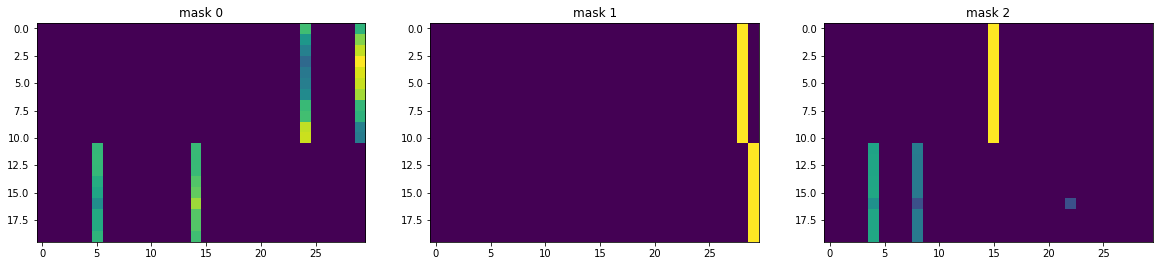

In [32]:
# shows masks per feature for first 20 rows
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:20])
    axs[i].set_title(f"mask {i}")

# Comparison to XGBoost and LightGBM

## XGBoost

In [33]:
from xgboost import XGBRegressor

In [34]:
%%time
# create XGB Regressor with slightly adjusted values (defaults are underfitting too much)
# takes about 30s
est_xgb = XGBRegressor( 
    max_depth=8, 
    n_estimators=5000,
    n_jobs=-1,
    learning_rate=0.03,
    subsample=0.7
    )

est_xgb.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)], eval_metric=['rmse'],
            early_stopping_rounds=10,
            verbose=25);

[10:45:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3814.89
Will train until validation_0-rmse hasn't improved in 10 rounds.
[25]	validation_0-rmse:1824.42
[50]	validation_0-rmse:900.924
[75]	validation_0-rmse:483.462
[100]	validation_0-rmse:312.564
[125]	validation_0-rmse:248.757
[150]	validation_0-rmse:229.107
[175]	validation_0-rmse:222.331
[200]	validation_0-rmse:220.965
Stopping. Best iteration:
[198]	validation_0-rmse:220.014

CPU times: user 25.7 s, sys: 50 ms, total: 25.7 s
Wall time: 25.7 s


In [35]:
xgb_preds_valid = est_xgb.predict(X_valid)
xgb_preds_test = est_xgb.predict(X_test)

xgb_valid_mse = metrics.mean_squared_error(y_true=y_valid, y_pred=xgb_preds_valid)
xgb_test_mse  = metrics.mean_squared_error(y_true=y_test, y_pred=xgb_preds_test)

print(f"XGB valid MSE: {xgb_valid_mse:,.2f}")
print(f"XGB test  MSE: {xgb_test_mse:,.2f}")

XGB valid MSE: 48,406.14
XGB test  MSE: 111,073.10


## LightGBM

In [36]:
from lightgbm import LGBMRegressor

In [37]:
%%time
# LightGBM Regressor with similar parameters to XGBoost
# takes about 5s
est_lgb = LGBMRegressor(num_leaves=2**7-1, objective='mse',
                        max_depth=8,
                        learning_rate=0.03,
                        n_estimators=5000, 
                        subsample=0.7,
                        random_stage=42)

est_lgb.fit(X_train, y_train, 
            eval_set=[(X_valid, y_valid)], eval_metric=['rmse'],
            early_stopping_rounds=10,
            verbose=100);

Training until validation scores don't improve for 10 rounds.
[100]	valid_0's rmse: 247.396	valid_0's l2: 61204.8
Early stopping, best iteration is:
[162]	valid_0's rmse: 218.656	valid_0's l2: 47810.3
CPU times: user 2.97 s, sys: 48 ms, total: 3.02 s
Wall time: 3.01 s


In [38]:
lgb_preds_valid = est_lgb.predict(X_valid)
lgb_preds_test  = est_lgb.predict(X_test)

lgb_valid_mse = metrics.mean_squared_error(y_true=y_valid, y_pred=lgb_preds_valid)
lgb_test_mse  = metrics.mean_squared_error(y_true=y_test, y_pred=lgb_preds_test)

print(f"LGB valid MSE: {lgb_valid_mse:,.2f}")
print(f"LGB test  MSE: {lgb_test_mse:,.2f}")

LGB valid MSE: 47,810.31
LGB test  MSE: 139,191.05


## all scores and feature importances

In [39]:
print('test set MSE scores:')
print(f'TabNet:   {tabnet_test_mse:,.0f}')
print(f'XGBoost:  {xgb_test_mse:,.0f}')
print(f'LightGBM: {lgb_test_mse:,.0f}')

test set MSE scores:
TabNet:   112,008
XGBoost:  111,073
LightGBM: 139,191


In [40]:
feat_imp = (pd.DataFrame({ 'feature':features_all
                          ,'importance_tabnet':np.round(est.feature_importances_, 4)
                          ,'importance_xgb':   np.round(est_xgb.feature_importances_, 4)
                          ,'importance_lgb':   np.round(est_lgb.feature_importances_, 4)
                         })
            #.sort_values('importance_tabnet', ascending=False)
            .reset_index(drop=True)
)

# LGBM feature importances sum to 1
feat_imp['importance_lgb'] = feat_imp['importance_lgb']/feat_imp['importance_lgb'].sum()

feat_imp.style.bar()

,feature,importance_tabnet,importance_xgb,importance_lgb
0,temp,0.000000,0.000900,0.105678
1,rain_1h,0.000000,0.001900,0.015090
2,snow_1h,0.000000,0.000400,0.000000
3,clouds_all,0.000000,0.000700,0.024203
4,dt_date_time_year,0.161900,0.001200,0.088188
5,dt_date_time_month,0.129800,0.002300,0.006173
6,dt_date_time_week,0.000000,0.001200,0.024301
7,dt_date_time_day,0.000000,0.002000,0.104600
8,dt_date_time_dayofweek,0.107200,0.033700,0.109451
9,dt_date_time_dayofyear,0.000000,0.003000,0.119249
